# HuBMAP-HHV baseline inference

This notebook is used to submit the predictions of a baseline Detectron2 model to the competition. The notebook can only run offline so all the necessary packages and data are taken from within kaggle. These datasets are:
- The original competition dataset [HuBMAP - Hacking the Human Vasculature](https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature)
- The Detectron2 model which was previously produced and uploaded in [hubmap-hhv-model-rn-101-cocov8](https://www.kaggle.com/datasets/theo88/hubmap-hhv-model-cocov8)
- A wheel package for the Detectron2 offline installation in [detectron2-wheel](https://www.kaggle.com/code/plugin1689/detectron2-wheel)

## Installing necessary packages offline

In [1]:
!pip install /kaggle/input/detectron2-wheel/detectron2/detectron2-0.6-cp310-cp310-linux_x86_64.whl --no-index --find-links=/kaggle/input/detectron2-wheel/detectron2

Looking in links: /kaggle/input/detectron2-wheel/detectron2
Processing /kaggle/input/detectron2-wheel/detectron2/detectron2-0.6-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/detectron2-wheel/detectron2/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl (from detectron2==0.6)
Processing /kaggle/input/detectron2-wheel/detectron2/yacs-0.1.8-py3-none-any.whl (from detectron2==0.6)
Processing /kaggle/input/detectron2-wheel/detectron2/fvcore-0.1.5.post20221221-py3-none-any.whl (from detectron2==0.6)
Processing /kaggle/input/detectron2-wheel/detectron2/iopath-0.1.9-py3-none-any.whl (from detectron2==0.6)
Processing /kaggle/input/detectron2-wheel/detectron2/omegaconf-2.3.0-py3-none-any.whl (from detectron2==0.6)
Processing /kaggle/input/detectron2-wheel/detectron2/hydra_core-1.3.2-py3-none-any.whl (from detectron2==0.6)
Processing /kaggle/input/detectron2-wheel/detectron2/black-23.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from detectron2==0.6)
Processing /kaggle/input

In [2]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import detectron2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('GPU is available')
else:
    DEVICE = torch.device('cpu')
    print('CPU is used')
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print('detectron2:', detectron2.__version__)

GPU is available
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  2.0.0
detectron2: 0.6


## Utility function for creating the encoded mask string 

In [4]:
import base64
from pycocotools import _mask as coco_mask
import typing as t
import zlib

def encode_binary_mask(mask: np.ndarray) -> t.Text:
  """Converts a binary mask into OID challenge encoding ascii text."""

  # check input mask --
  if mask.dtype != bool:
    raise ValueError(
        "encode_binary_mask expects a binary mask, received dtype == %s" %
        mask.dtype)

  mask = np.squeeze(mask)
  if len(mask.shape) != 2:
    raise ValueError(
        "encode_binary_mask expects a 2d mask, received shape == %s" %
        mask.shape)

  # convert input mask to expected COCO API input --
  mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
  mask_to_encode = mask_to_encode.astype(np.uint8)
  mask_to_encode = np.asfortranarray(mask_to_encode)

  # RLE encode mask --
  encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

  # compress and base64 encoding --
  binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
  base64_str = base64.b64encode(binary_str)
  return base64_str

## Configuration of model for inference

### Hyperparameters

In [5]:
BV_CLASS = 0
GL_CLASS = 1
NUM_CLASSES = 2
# model_path = "/kaggle/input/hubmap-hhv-model-cocov8"
# model_name = "model_final.pth"
# model_cfg = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
model_path = "/kaggle/input/hubmap-hhv-model-rn-101-cocov8"
model_name = "model_0004999.pth"
model_cfg = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

model_weights_path = os.path.join(model_path, model_name) 
thr_conf=0.08 # threshold of confidence for the blood_vessels
min_size_threshold = 10 # minimum size of instance

In [6]:
# Configuration parameters of the model for inference
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_cfg))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
cfg.MODEL.WEIGHTS = model_weights_path

predictor = DefaultPredictor(cfg)

In [7]:
INPUT_PATH = '/kaggle/input/hubmap-hacking-the-human-vasculature'
test_images_path = os.path.join(INPUT_PATH,'test')
all_imgs = glob.glob(os.path.join(test_images_path, '*.tif'))
test_len = len(all_imgs)
DEBUG = test_len == 1 
all_imgs, os.path.splitext(os.path.basename(all_imgs[0]))[0], test_len

(['/kaggle/input/hubmap-hacking-the-human-vasculature/test/72e40acccadf.tif'],
 '72e40acccadf',
 1)

### Visualize samples of training images

For debugging purposes we visualize some sample images from the training set with their masks (ground truth) and next to them the predicted images of the model.

It must be noted that during submission the `DEBUG` flag is set to `False` so the visualizaions are not executed

In [8]:
from scipy.ndimage import label
from scipy.ndimage import find_objects
import json
import glob

# Loads the original training set for visualization
if DEBUG:
    INPUT_PATH = '/kaggle/input/hubmap-hacking-the-human-vasculature'
    train_images_path = os.path.join(INPUT_PATH, 'train')
    IMG_SIZE = 512
    annotation_types = ['blood_vessel', 'glomerulus', 'unsure']
    images = {}
    masks = {}
    def create_mask(image_id, shape, polygons):
        """
        Function to load all masks (annotations) of an image into the masks dictionary.
        It also records several statistics categorized per annotation type like:
        number of annotations, total area and sum of squared areas (used for std calculation later on)
        """

        masks[image_id] = {annotation_type: {'count': 0, 'area': 0, 'sum_sq_area': 0, 
                                             'image':np.zeros(shape, dtype=np.uint8)} 
                                               for annotation_type in annotation_types}
        # For each polygon
        for polygon in polygons:
            annotation_type = polygon['type']
            lines = np.array(polygon['coordinates'])
            lines = lines.reshape(-1, 1, 2)
            # Draw the polygon on the mask
            mask = masks[image_id][annotation_type]['image']
            cv2.fillPoly(mask, [lines], 1)

        for t in annotation_types:
            mask = masks[image_id][t]['image']
            # Calculate the areas of the mask
            labels, n_labels = label(mask)
            f = find_objects(labels)
            total_area = 0
            instances = []
            for i in range(n_labels):
                instance_area = np.sum(labels[f[i]]//(i+1))
                instances.append(instance_area)
                total_area += instance_area

            masks[image_id][t]['count'] = n_labels # number of instances per type
            masks[image_id][t]['area'] = total_area # total area of all instances
            masks[image_id][t]['sum_sq_area'] = np.sum(np.array(instances)**2) # sum of squared areas

    # Open the JSON file and read all images in RBG format + create masks
    with open(os.path.join(INPUT_PATH, 'polygons.jsonl'), 'r') as file:
        for line in file:
            json_data = json.loads(line)
            image_id = json_data['id']
            # Load image
            fn = os.path.join(train_images_path, image_id + '.tif')
            assert(os.path.exists(fn))
            img = cv2.imread(fn, cv2.IMREAD_UNCHANGED)
            images[image_id] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            shape = img.shape[:2]
            assert(shape==(IMG_SIZE, IMG_SIZE))
            del img
            # Create masks
            create_mask(image_id, shape, json_data['annotations'])

    train_images = glob.glob(os.path.join(train_images_path, '*.tif'))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
def get_prediction(image, all_classes=False):
    """
    A function that takes as an input an image in BGR format, performs the prediction
    and filters out all the predicted images that are below its class threshold.
    In case all_classes==False, it takes into account only the first class
    Returns: the predicted masks, classes and scores
    """
    if all_classes:
        thresholds_classes = {0: thr_conf, 1: 0.2, 2: 0.2}
    else:
        thresholds_classes = {0: 0.25}
    output = predictor(image)
    take = torch.zeros(len(output['instances'].scores), dtype=torch.bool).to(device=DEVICE)
    # filter  based on thresholds for each class
    for c in thresholds_classes:
        mask = (output['instances'].pred_classes == c) & \
                (output['instances'].scores > thresholds_classes[c])
        take |= mask
    pred_masks = output['instances'].pred_masks[take].cpu().numpy()
    pred_classes = output['instances'].pred_classes[take].cpu().numpy()
    pred_scores = output['instances'].scores[take].cpu().numpy()
    
    return pred_masks, pred_classes, pred_scores 

In [10]:
def remove_gl_from_mask(mask, all_masks, classes):
    """
    Remove from blodd_vessels masks the glomerulus part and returns 
    the new mask
    """
    for idx, glmask in enumerate(all_masks):
        if classes[idx] == GL_CLASS:
            mask &= ~glmask
            
    return mask

In [19]:
def display_gt_and_predicted(image_id, all_classes=False):
    """
    Given an image_id as input, the image is displayed in RGB, 
    overlayed with the ground truth masks.
    Next to it the prediction masks are displayed for comparison.
    """
    image = images[image_id]
    mask = masks[image_id]
    combined_mask = np.zeros(image.shape[:2])
    overlay = image.copy()
    # Colors for blood vessels, glomerulus and unsure respectively
    colors = [(255, 0, 0), (0, 0, 255), (0, 206, 209)]  
    colorsRBG = [tuple(c / 255 for c in tup) for tup in colors] 
    
    # Initialize dictionary to hold annotation counts
    annotation_counts = {}
    for i, a_t in enumerate(mask.keys()):
        annotation_counts[a_t] = mask[a_t]['count']
        # update overlay
        overlay[mask[a_t]['image'] > 0] = colors[i]
        combined_mask += mask[a_t]['image'] * (i+1)
        
    # prepare for subplot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the ground truth
    axs[0].imshow(image)  # Use RGB image
    axs[0].imshow(overlay, alpha=0.4)  # change alpha to adjust transparency
    axs[0].set_title('Ground Truth')

    # Plot the prediction
    colors = ['Set1', 'Set2', 'Set4'] 
    pred_masks,pred_classes,pred_scores = get_prediction(image, all_classes=True)
    print(pred_classes)
    axs[1].imshow(image)
    axs[1].set_title('Predicted Masks')

    for mk,cl,sc in zip(pred_masks,pred_classes,pred_scores):
        if not all_classes and int(cl) != BV_CLASS: continue
        if sc<thr_conf: continue
        color = colors[cl]
        mask = np.ma.masked_where(mk == 0, mk)
        # Remove from blodd_vessels masks the glomerulus part
        if int(cl) == BV_CLASS:
            mask = remove_gl_from_mask(mask, pred_masks, pred_classes)
        if (mask.sum()>min_size_threshold):
            axs[1].imshow(mask, cmap=color, alpha=0.8)
            # Add score text on each segment
            y, x = np.where(mk > 0)
            text_x, text_y = np.min(x), np.max(y)
            axs[1].text(text_x, text_y, f"{sc:.2f}", color='black', fontsize=10)
    plt.show()

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


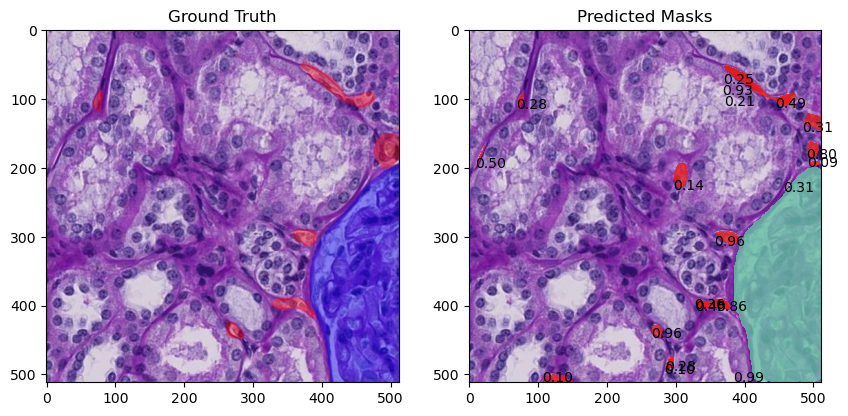

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


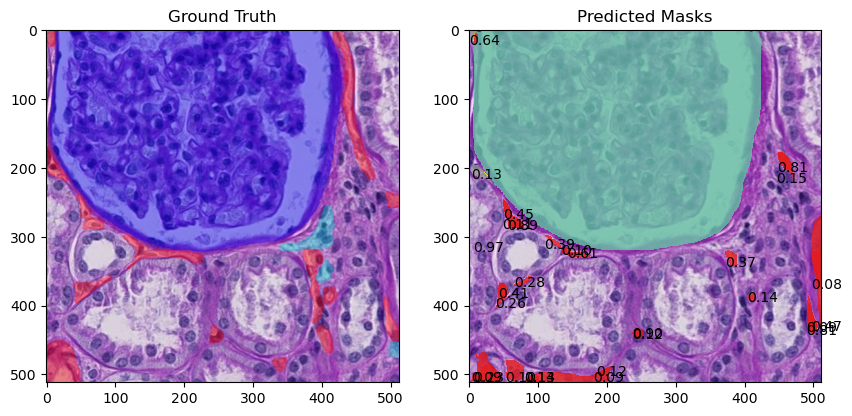

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


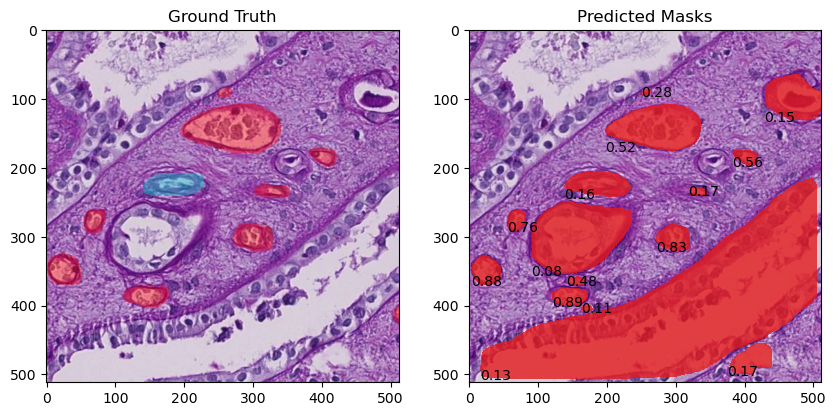

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


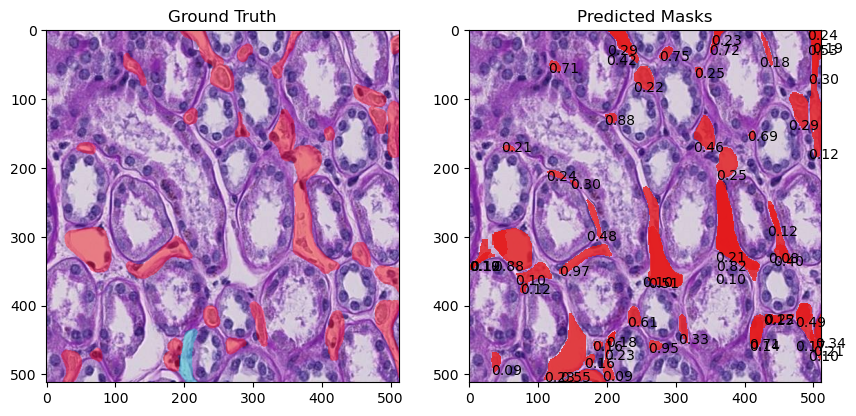

In [20]:
# Display some sample images
if DEBUG:
    image_ids = ['097dd2ed6c14', '0754412b2917', '00656c6f2690', '06b972c417e7']
    for im_id in image_ids: 
        display_gt_and_predicted(im_id, all_classes=True)

## Inference on test set

In [13]:
ids = []
heights = []
widths = []
prediction_strings = []

In [14]:
for idx, img_path in enumerate(all_imgs):
    image = cv2.imread(img_path)
    h, w, _ = image.shape
    pred_masks, pred_classes, pred_scores = get_prediction(image, all_classes=True)
    pred_string = ''
    for i, (mask,scr) in enumerate(zip(pred_masks,pred_scores)):
        # only blood_vessel class is needed for the competition
        if int(pred_classes[i]) != BV_CLASS: continue
        if float(pred_scores[i]) < thr_conf: continue
        # Remove from blodd_vessels masks the glomerulus part
        mask = remove_gl_from_mask(mask, pred_masks, pred_classes)
        if (mask.sum() > min_size_threshold):
            encoded = encode_binary_mask(mask)
            pred_string += ("" if i==0 else " ") + f"0 {pred_scores[i]} {encoded.decode('utf-8')}"

    ids.append(os.path.splitext(os.path.basename(img_path))[0])
    heights.append(h)
    widths.append(w)
    prediction_strings.append(pred_string)

## Visualizing the outcoume in the testset

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


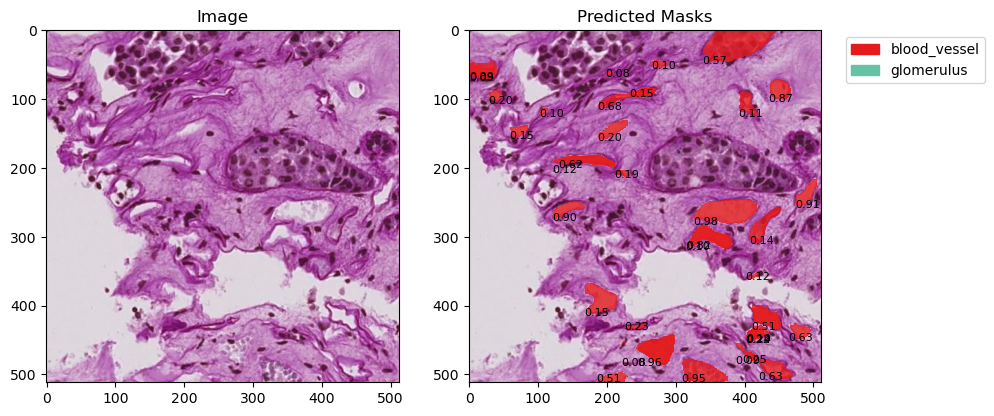

In [15]:
import matplotlib.patches as mpatches

if DEBUG:
    colors = ['Set1', 'Set2', 'Set4'] 
    legend = {0: 'blood_vessel', 1: 'glomerulus'} 
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    I = cv2.imread(all_imgs[0])
    axs[0].imshow(I)
    axs[0].set_title('Image')
    axs[1].imshow(I)
    axs[1].set_title('Predicted Masks')
    print(pred_classes)
    for mk,cl,sc in zip(pred_masks,pred_classes,pred_scores):
        if sc<thr_conf:continue    
#         if int(cl) == BV_CLASS: continue
        color = colors[cl]
        mask = np.ma.masked_where(mk == 0, mk)
        if cl == BV_CLASS:
            ms1 = mask.sum()
            mask = remove_gl_from_mask(mask, pred_masks, pred_classes)
            # Debug output for removed parts of blood vessels
            if ms1 != mask.sum():
                print(ms1, f"{sc:.2f}")
                print(mask.sum(), f"{sc:.2f}")
        if (mask.sum() > min_size_threshold):
            axs[1].imshow(mask, cmap=color, alpha=0.8)
            # Add score text on each segment
            y, x = np.where(mk > 0)
            if cl == BV_CLASS:
                text_x, text_y = np.min(x), np.max(y)  
            else: 
                text_x, text_y = np.mean(x), np.mean(y) 
#             print(sc)
            axs[1].text(text_x, text_y, f"{sc:.2f}", color='black', fontsize=8)
        handles = []
        for cl in legend:
            color = colors[cl]
            handles.append(mpatches.Patch(color=plt.colormaps.get_cmap(color)(0)))
        axs[1].legend(handles, legend.values(), bbox_to_anchor=(1.05, 1), loc='upper left')

## Create the submission file

In [16]:
submission = pd.DataFrame()
submission['id'] = ids
submission['height'] = heights
submission['width'] = widths
submission['prediction_string'] = prediction_strings
submission = submission.set_index('id')
submission.to_csv("submission.csv")
submission.head()

,height,width,prediction_string
id,,,
72e40acccadf,512,512,0 0.9830617904663086 eNpLyggyNc6wN/M18jfyAWJ/Q...
